<a href="https://colab.research.google.com/github/oz-e/applied-ml/blob/main/attn_map_CuPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    if not os.path.exists('/content/Transformer-MM-Explainability/'):
        # Use custom CLIP to show the attention map
        %cd /content/
        !git clone https://github.com/hila-chefer/Transformer-MM-Explainability
        !cp -r /content/Transformer-MM-Explainability/CLIP/clip/ /content/applied-ml/

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install ftfy
    !pip install captum
    !pip install numpy==2.0.2

Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAILX4Mpga8HoYspDolWelRTP5bqRq5adB3yhqg60Nu4Fh root@41d483a622af

Please use SSH method to clone repo.
Cloning into 'applied-ml'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 159 (delta 5), reused 0 (delta 0), pack-reused 144 (from 1)
Receiving objects: 100% (159/159), 4.01 MiB | 2.52 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1477 (delta 90), reused 66 (delta 66), pack-reused 1348 (from 1)
Receiving objects: 100% (1477/1477), 29.01 MiB | 11.39 MiB/s, d

In [3]:
import os

if not os.path.exists("CuPL"):
    !git clone https://github.com/sarahpratt/CuPL.git

Cloning into 'CuPL'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 6), reused 52 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 4.68 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)

100%|███████████████████████████████████████| 351M/351M [00:04<00:00, 74.0MiB/s]


In [7]:
import aml.datasets

all_images = aml.datasets.Flowers102(datasets_path, split='test')

100%|██████████| 345M/345M [00:17<00:00, 19.7MB/s]
100%|██████████| 502/502 [00:00<00:00, 898kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 24.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pp0sRXzZFZq15zVOzKjKBu4A9i01nozT
To: /content/applied-ml/datasets/flowers-102/split.json
100%|██████████| 771k/771k [00:00<00:00, 120MB/s]


In [8]:
from collections import defaultdict

grouped_images = defaultdict(list)
for image, label in all_images:
    grouped_images[label].append(image)

In [9]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/flower_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts = json.load(f)

In [10]:
special_class_mapping = {
    'globe flower': 'globe-flower',
    'pink and yellow dahlia': 'pink-yellow dahlia',
    'air plant': 'ball moss',
}

In [11]:
# For bridging classsname in dataset with name in CuLP prompts
new_gpt3_prompts = {}

for key, value in gpt3_prompts.items():
    new_key = special_class_mapping.get(key, key)
    new_gpt3_prompts[new_key.lower()] = value

In [12]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [13]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [14]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [15]:
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [16]:
cls_id = 5

cls_name = all_images.lab2cname[cls_id]
org_img = grouped_images[cls_id][0]

tiger lily


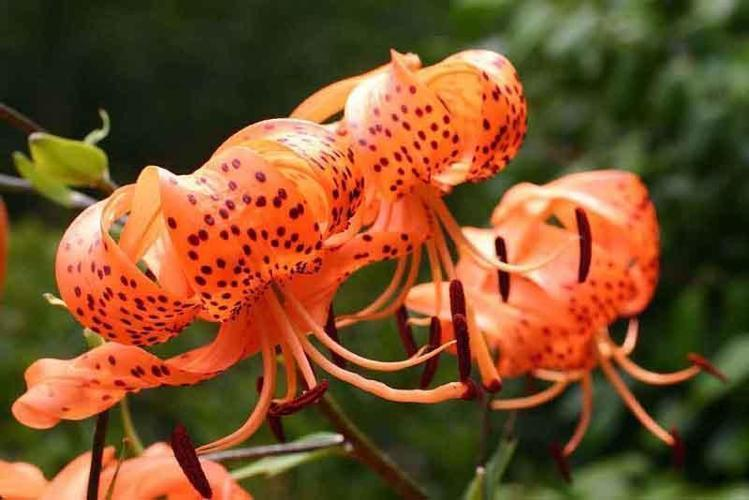

In [17]:
print(cls_name)
org_img

In [18]:
new_gpt3_prompts[cls_name]

['A tiger lily has large, orange flowers with black spots.',
 'A tiger lily is a type of flower with orange or red petals and black spots.',
 'Tiger lilies are typically orange or red and have black spots.',
 'One way to identify a tiger lily is by its large, showy, orange flowers with black spots.',
 'Tiger lilies are a type of lily that are orange or reddish in color and have black spots.',
 'The tiger lily is a member of the lily family.',
 'Identify a tiger lily by its orange or yellow petals with black spots.',
 'The tiger lily is a flower that is red with orange stripes.',
 '.',
 'The tiger lily is a large flower with long, pointed petals.',
 'A tiger lily flower is a large, showy flower with long, pointed petals and a prominent center.',
 'Tiger lily flowers are orange with black spots and have long, trumpet-shaped petals.',
 'The tiger lily (Lilium columbianum) is a species of lily that is native to northwestern North America.',
 'A tiger lily is a tall, striking flower that is

tensor([0.0121, 0.2042, 0.2284, 0.0000, 0.0057, 0.0019, 0.1949, 0.0446, 0.0084,
        0.0061, 0.2861, 0.0074], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"a tiger lily has large , orange flowers with black spots ."


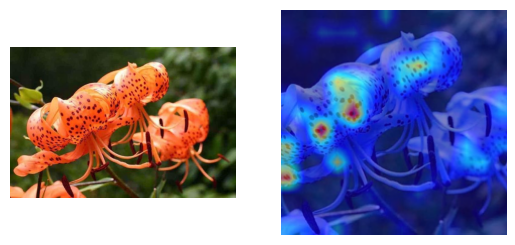

tensor([9.6817e-03, 1.0156e-01, 3.3618e-01, 0.0000e+00, 1.0061e-04, 2.1896e-03,
        1.2755e-05, 4.7089e-02, 3.8967e-03, 1.0864e-01, 1.9121e-03, 2.2934e-02,
        1.1896e-01, 4.0054e-03, 1.9627e-03, 2.3669e-01, 4.3488e-03],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a tiger lily is a type of flower with orange or red petals and black spots .


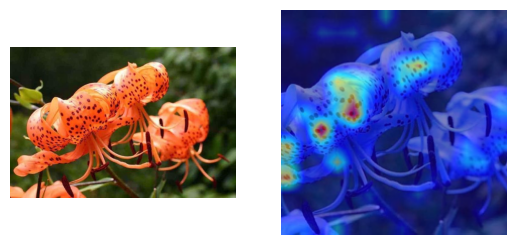

tensor([0.1125, 0.5088, 0.0125, 0.0027, 0.0860, 0.0033, 0.0283, 0.0075, 0.0076,
        0.0000, 0.2211, 0.0101], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,tiger lilies are typically orange or red and have black spots .


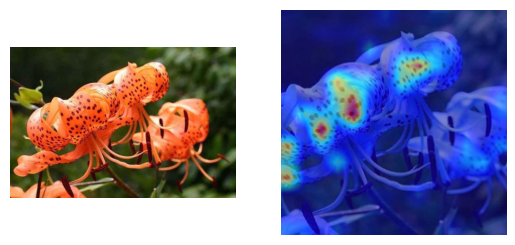

In [19]:
img = preprocess(org_img).unsqueeze(0).to(device)
texts = new_gpt3_prompts[cls_name][:3]  # choose the first few prompts as examples
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=org_img)
  plt.show()

tensor([0.0097, 0.0225, 0.0592, 0.0370, 0.0059, 0.1614, 0.6992, 0.0050],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a bad photo of a tiger lily .


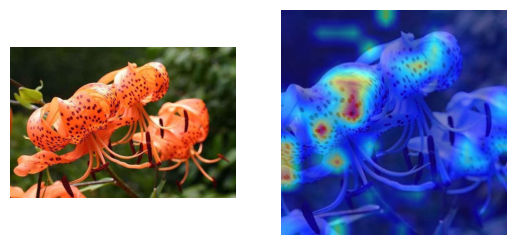

tensor([0.0157, 0.0232, 0.0906, 0.0012, 0.2461, 0.6030, 0.0198],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of many tiger lily .


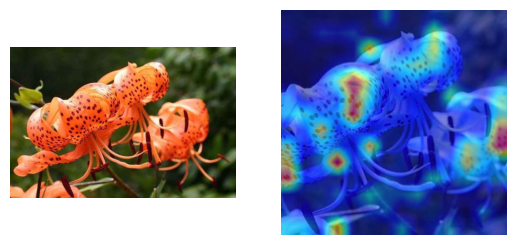

tensor([2.8564e-02, 1.1330e-03, 0.0000e+00, 1.5473e-04, 5.3650e-02, 9.1650e-01,
        0.0000e+00], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a sculpture of a tiger lily .


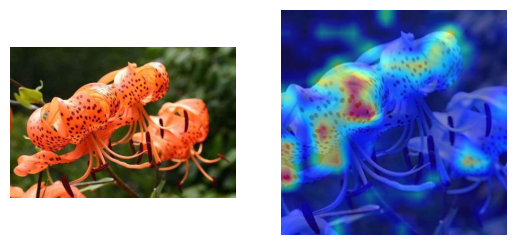

In [20]:
img = preprocess(org_img).unsqueeze(0).to(device)
texts = [template.format(cls_name) for template in imagenet_templates[:3]]  # choose the first few prompts as examples
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=org_img)
  plt.show()